In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/demand-forecasting-kernels-only/test.csv
/kaggle/input/demand-forecasting-kernels-only/sample_submission.csv
/kaggle/input/demand-forecasting-kernels-only/train.csv


## Data wrangling
Our task is to forecast monthly total sales. We need to aggregate our data at the monthly level and sum up the sales column.

In [2]:
# read data from train.csv
df_sales = pd.read_csv("/kaggle/input/demand-forecasting-kernels-only/train.csv")
df_sales.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [3]:
print(type(df_sales['date'][0]))

# convert date in datetime format
df_sales['date'] = pd.to_datetime(df_sales['date'])
df_sales.head()

<class 'str'>


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [4]:
# calculate monthly total sales

# convert all dates in a month as same
df_sales['date'] = df_sales['date'].dt.year.astype('str') + '-' + df_sales['date'].dt.month.astype('str') + '-01'
df_sales['date'] = pd.to_datetime(df_sales['date'])
print(df_sales.head())

# group the dates and sum the sales
df_sales = df_sales.groupby('date').sales.sum().reset_index()
df_sales.head()

        date  store  item  sales
0 2013-01-01      1     1     13
1 2013-01-01      1     1     11
2 2013-01-01      1     1     14
3 2013-01-01      1     1     13
4 2013-01-01      1     1     10


,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242


## Data Transformation
To model our forecast easier and more accurate, we will do the transformations below:
* We will convert the data to stationary if it is not
* Converting from time series to supervised for having the feature set of our LSTM model
* Scale the data

First off, how do we check if the data is not stationary? Let’s plot it and see:

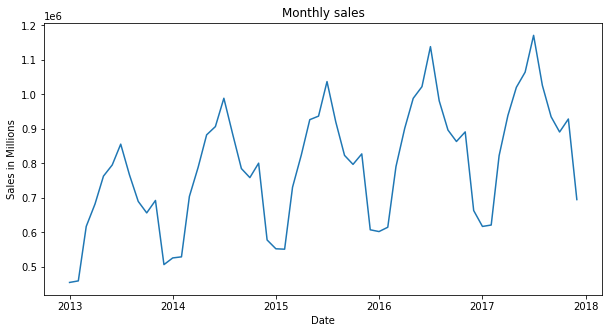

In [5]:
# plot monthly sales with matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,5))
plt.plot(df_sales['date'], df_sales['sales'])
plt.title("Monthly sales")
plt.xlabel("Date")
plt.ylabel("Sales in Millions")
plt.show()

In [6]:
# plot monthly sales with plotly
import plotly.offline as pyoff
import plotly.graph_objs as go

plot_data = [go.Scatter(x=df_sales['date'], y=df_sales['sales'])]
plot_layout = go.Layout(title="Monthly Sales")

fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

Obviously, it is not stationary and has an increasing trend over the months. One method is to get the difference in sales compared to the previous month and build the model on it:

In [7]:
# creating a new dataframe to model the difference
df_diff = df_sales.copy()

df_diff['prev_sales'] = df_diff['sales'].shift(1)
df_diff = df_diff.dropna()
df_diff['diff'] = df_diff['sales']-df_diff['prev_sales']

df_diff.head()

,date,sales,prev_sales,diff
1,2013-02-01,459417,454904.0,4513.0
2,2013-03-01,617382,459417.0,157965.0
3,2013-04-01,682274,617382.0,64892.0
4,2013-05-01,763242,682274.0,80968.0
5,2013-06-01,795597,763242.0,32355.0


In [8]:
# plotting the difference between the monthly sales
plot_data= [go.Scatter(x=df_diff['date'], y=df_diff['diff'])]
plot_layout = go.Layout(title="Monthly difference between sales")

fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

Perfect! Our Monthly sales difference is stationary. Now we can start building our feature set. We need to use previous monthly sales data to forecast the next ones. The look-back period may vary for every model. Ours will be 12 for this project.

In [9]:
#create dataframe for transformation from time series to supervised
df_supervised = df_diff.drop(['prev_sales'], axis=1)

# we will look for last 12 months to predict
for i in range(1,13):
    label_name = 'lag_'+str(i)
    df_supervised[label_name] = df_supervised['diff'].shift(i)

df_supervised = df_supervised.dropna().reset_index(drop=True)
df_supervised.head()

,date,sales,diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
0,2014-02-01,529117,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,2014-03-01,704301,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,2014-04-01,788914,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,2014-05-01,882877,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,2014-06-01,906842,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0


But there is one more step before scaling. We should split our data into train and test sets. As the test set, we have selected the last 6 months’ sales.

In [10]:
# create a new dataframe for LSTM model
df_model = df_supervised.drop(['sales', 'date'], axis=1)

# split train and test set(last 6 months)
train_set, test_set = df_model[:-6].values, df_model[-6:].values

In [11]:
# apply Min Max Scaler
import sklearn
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train_set)

train_set_scaled = scaler.transform(train_set)
test_set_scaled = scaler.transform(test_set)

# Building the LSTM model

Let’s create feature and label sets from scaled datasets:

In [12]:
# train and test set
x_train, y_train = train_set_scaled[:,1:], train_set_scaled[:, :1]
x_train = x_train.reshape(x_train.shape[0], 1, x_train.shape[1])

x_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, :1]
x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])

In [13]:
# model construction and training
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(4, stateful=True),
    tf.keras.layers.Dense(1)
])

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=100, batch_size=1, verbose=1)


Epoch 1/100
41/41 [==============================] - 0s 1ms/step - loss: 0.3462
Epoch 2/100
41/41 [==============================] - 0s 1ms/step - loss: 0.2741
Epoch 3/100
41/41 [==============================] - 0s 1ms/step - loss: 0.2325
Epoch 4/100
41/41 [==============================] - 0s 1ms/step - loss: 0.2060
Epoch 5/100
41/41 [==============================] - 0s 1ms/step - loss: 0.1936
Epoch 6/100
41/41 [==============================] - 0s 1ms/step - loss: 0.1772
Epoch 7/100
41/41 [==============================] - 0s 1ms/step - loss: 0.1789
Epoch 8/100
41/41 [==============================] - 0s 1ms/step - loss: 0.1625
Epoch 9/100
41/41 [==============================] - 0s 1ms/step - loss: 0.1545
Epoch 10/100
41/41 [==============================] - 0s 1ms/step - loss: 0.1053
Epoch 11/100
41/41 [==============================] - 0s 1ms/step - loss: 0.1249
Epoch 12/100
41/41 [==============================] - 0s 1ms/step - loss: 0.1144
Epoch 13/100
41/41 [=================

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (1, 4)                    272       
_________________________________________________________________
dense (Dense)                (1, 1)                    5         
Total params: 277
Trainable params: 277
Non-trainable params: 0
_________________________________________________________________


In [15]:
# prediction on test set
y_pred = model.predict(x_test,batch_size=1)
print("prediction: \n", y_pred)
print("Actual: \n",y_test)

prediction: 
 [[ 0.6310524 ]
 [-0.4783835 ]
 [-0.39789042]
 [-0.06838901]
 [ 0.25898644]
 [-0.9804728 ]]
Actual: 
 [[ 0.55964922]
 [-0.61313659]
 [-0.36228353]
 [-0.14316792]
 [ 0.23779333]
 [-1.02622661]]


Results look similar but it doesn’t tell us much because these are scaled data that shows the difference. We can see the actual sales prediction by rescaling it to original form.

In [16]:
# inverse transformation for scaling

#reshape y_pred
y_pred = y_pred.reshape(y_pred.shape[0], 1, y_pred.shape[1])
#rebuild test set for inverse transform
pred_test_set = []
for index in range(0,len(y_pred)):
    pred_test_set.append(np.concatenate([y_pred[index],x_test[index]],axis=1))
#reshape pred_test_set
pred_test_set = np.array(pred_test_set)
pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])
#inverse transform
pred_test_set_inverted = scaler.inverse_transform(pred_test_set)

In [17]:
#create dataframe that shows the predicted sales
result_list = []
sales_dates = list(df_sales[-7:].date)
act_sales = list(df_sales[-7:].sales)
for index in range(0,len(pred_test_set_inverted)):
    result_dict = {}
    result_dict['pred_value'] = int(pred_test_set_inverted[index][0] + act_sales[index])
    result_dict['date'] = sales_dates[index+1]
    result_list.append(result_dict)
df_result = pd.DataFrame(result_list)
df_result

,pred_value,date
0,1186720,2017-07-01
1,1055330,2017-08-01
2,927619,2017-09-01
3,907212,2017-10-01
4,933386,2017-11-01
5,704991,2017-12-01


In [18]:
#merge with actual sales dataframe
df_sales_pred = pd.merge(df_sales,df_result,on='date',how='left')
df_sales_pred

,date,sales,pred_value
0,2013-01-01,454904,NaN
1,2013-02-01,459417,NaN
2,2013-03-01,617382,NaN
3,2013-04-01,682274,NaN
4,2013-05-01,763242,NaN
5,2013-06-01,795597,NaN
6,2013-07-01,855922,NaN
7,2013-08-01,766761,NaN
8,2013-09-01,689907,NaN
9,2013-10-01,656587,NaN


In [19]:
#plot actual vs predicted
plot_data = [
    go.Scatter(
        x=df_sales_pred['date'],
        y=df_sales_pred['sales'],
        name='actual'
    ),
        go.Scatter(
        x=df_sales_pred['date'],
        y=df_sales_pred['pred_value'],
        name='predicted'
    )
    
]
plot_layout = go.Layout(
        title='Sales Prediction'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)